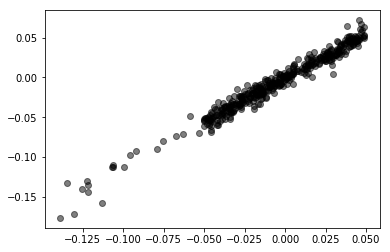

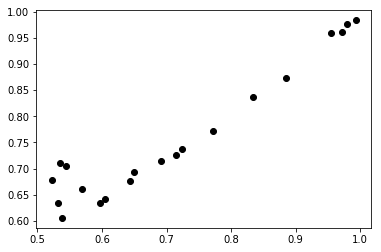

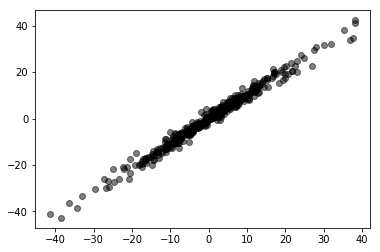

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.optimize as spo
import numpy.linalg as npl
import numpy.random as npr
from scipy.special import erf
%matplotlib inline

root2over = 1/np.sqrt(2)

def simulate(size,time_steps,w = 0.0,sigma = 1.0,coupling = 1.0,rho = 0.5):
    if npl.norm(w)==0.:
        sigma = (npr.rand(1,size)+1)/2.0
        w = npr.rand(size,size) - 0.5
    #     w = w.dot(w.T)
        w = coupling*(w-np.eye(size))
    x = np.zeros((time_steps,size))
    x_min = np.zeros((1,size))
    x[0] = npr.rand(1,size)
    for i in range(time_steps-1):
        x[i+1] = x[i] + x[i].dot(w) + sigma*npr.normal(size=(1,size))
#         x[i+1] = np.maximum(x_min,(1-rho)*x[i] + rho*np.sqrt(np.maximum(x_min,x[i].dot(w)))) \
#                             + np.exp(sigma*npr.normal(size=(1,size)))
    return x-np.mean(x,axis=0)[np.newaxis,:],w,sigma

def find_sigma(y,h):
    time_steps,size = y.shape
    sigma = np.std(y-h,axis=0)
#     sigma = np.random.rand(1,size) + 0.5
#     for index in range(size):
#         def f0(sig):
#             return (1-np.std(y[:,index]/np.abs(sig) - h[:,index]))**2
#         res = spo.minimize(f0,sigma[0,index])
#         sigma[0,index] = np.abs(res.x)
    return(sigma.reshape(1,size))

def time_shift_cov(x,shift=1):
    time_steps,size = x.shape
    x0 = x - np.mean(x,axis=0)
    return x0[shift:].T.dot(x0[:-shift])/np.float(time_steps-shift)

def infer(x,max_iter = 50,tol=1e-6):
    time_steps,size = x.shape
    x0 = x[:-1] - np.mean(x[:-1],axis=0)
    y = np.diff(x,axis=0)
    y -= np.mean(y,axis=0)
    s = np.sign(y)
    c = np.cov(x,rowvar=False)
    w = npr.rand(size,size) - 0.5
    h = x0.dot(w)
    for index in range(size):
        err_old,error = 0,np.inf
#         print(index)
        while np.abs(error-err_old) > tol:
            w[:,index] = npl.solve(c+tol*np.eye(size),np.mean(x0*(s[:,index]*h[:,index]/erf(h[:,index]*root2over))[:,np.newaxis],axis=0))
            err_old = error
            h[:,index] = x0.dot(w[:,index])
            error = npl.norm(s[:,index]-erf(h[:,index]*root2over))
    sigma = find_sigma(y,h)
    return w*sigma[0][None,:],sigma

np.random.seed(31)
x_true,w_true,sig_true = simulate(20,10000,coupling=0.1)
w,sig = infer(x_true)
plt.plot(w_true,w,'ko',alpha=0.5)
plt.show()
plt.close()
plt.plot(sig_true,sig,'ko')
plt.show()
plt.close()

time_steps,size = x_true.shape
x_sim,w_sim,sig_sim = simulate(size,time_steps,w=w,sigma=sig)
plt.plot(time_shift_cov(x_true,shift=10),time_shift_cov(x_sim,shift=10),'ko',alpha=0.5)
plt.show()
plt.close()